# Complete Pipeline: Clustering, Classification, Optimization and SHAP Explainability

This notebook contains the complete and self-contained pipeline for analyzing student profiles from the MAMBA research group. The process is as follows:

1. **Data Loading and Preparation:** The dataset is loaded and the variables to be used are defined.
2. **Data Splitting:** Data is separated into training and test sets.
3. **Preprocessing and Clustering:** A pipeline is applied that normalizes numerical data, encodes categorical data, and then uses a GMM model to assign a cluster (profile) to each student in the training and test sets.
4. **Resampling (Oversampling):** Classes (clusters) are balanced in the training set so that each profile has 100 samples, avoiding biases in the model.
5. **Model Definition and Hyperparameter Grid:** The 6 models to be compared and their respective configurations for optimization with `GridSearchCV` are defined.
6. **Training and Optimization:** Each model is trained with its default configuration and then the best possible configuration is searched through `GridSearchCV`. All metrics are saved.
7. **Comparative Visualization:** A bar chart is generated to compare the F1-Score of the 12 models (6 baseline vs. 6 optimized).
8. **Feature Importance Analysis:** The best overall model is identified and the variables that most influenced its predictions are visualized.
9. **SHAP Explainability Analysis:** Deep analysis of model predictions using SHAP values with multiple visualizations.

## Import Libraries

In [4]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils import resample
import shap

# Visualization and warnings setup
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_style('whitegrid')

print('All libraries imported successfully!')
print(f'SHAP version: {shap.__version__}')

All libraries imported successfully!
SHAP version: 0.49.1


## 1. Data Loading and Preparation

In [5]:
print('--- 1. Data Loading and Preparation ---')
df = pd.read_excel('./RespuestasSemillero.xlsx')

features = ['Q5', 'Q7', 'Q8', 'Q9', 'Q10', 'Q23', 'Q25', 'Q30', 'Q31']
X = df[features]
y_placeholder = df['Q6']  # Placeholder for initial split

print(f'Dataset shape: {df.shape}')
print(f'Features selected: {features}')

--- 1. Data Loading and Preparation ---
Dataset shape: (81, 35)
Features selected: ['Q5', 'Q7', 'Q8', 'Q9', 'Q10', 'Q23', 'Q25', 'Q30', 'Q31']


## 2. Data Splitting

In [6]:
print('--- 2. Data Splitting ---')
X_train, X_test, _, _ = train_test_split(X, y_placeholder, test_size=0.4, random_state=42)
print(f'Training set size: {X_train.shape[0]} rows')
print(f'Test set size: {X_test.shape[0]} rows')

--- 2. Data Splitting ---
Training set size: 48 rows
Test set size: 33 rows


## 3. Preprocessing and Clustering

In [7]:
print('--- 3. Preprocessing and Clustering ---')
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)])

clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', GaussianMixture(n_components=3, random_state=42))])

# Train the clustering pipeline ONLY with training data
clustering_pipeline.fit(X_train)

# Generate labels (profiles) for both sets
y_train = clustering_pipeline.predict(X_train)
y_test = clustering_pipeline.predict(X_test)

# Convert to pandas Series for easier handling
y_train = pd.Series(y_train, index=X_train.index, name='cluster')
y_test = pd.Series(y_test, index=X_test.index, name='cluster')

print('Cluster distribution in training set:')
print(y_train.value_counts())
print('\nCluster distribution in test set:')
print(y_test.value_counts())

--- 3. Preprocessing and Clustering ---
Cluster distribution in training set:
cluster
2    24
1    15
0     9
Name: count, dtype: int64

Cluster distribution in test set:
cluster
2    18
0    12
1     3
Name: count, dtype: int64


## 4. Resampling (Oversampling) of Training Set

In [8]:
print('--- 4. Resampling (Oversampling) of Training Set ---')
# Process training data to combine with labels
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

train_processed_df = pd.DataFrame(X_train_processed)
train_processed_df['cluster'] = y_train.values

resampled_dfs = []
for label in train_processed_df['cluster'].unique():
    cluster_df = train_processed_df[train_processed_df['cluster'] == label]
    resampled_cluster = resample(cluster_df, replace=True, n_samples=1000, random_state=42)
    resampled_dfs.append(resampled_cluster)

resampled_train_df = pd.concat(resampled_dfs)
X_train_resampled = resampled_train_df.drop('cluster', axis=1).values
y_train_resampled = resampled_train_df['cluster'].values

print('New cluster distribution in resampled training set:')
print(pd.Series(y_train_resampled).value_counts())

--- 4. Resampling (Oversampling) of Training Set ---
New cluster distribution in resampled training set:
1    1000
2    1000
0    1000
Name: count, dtype: int64


## 5. Model Definition and Hyperparameter Grid

In [9]:
print('--- 5. Model Definition and Hyperparameter Grid ---')
models = {
    'LogReg': LogisticRegression(random_state=42, max_iter=2000),
    'RandForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'SVC': SVC(random_state=42, probability=True),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(random_state=42, max_iter=1500)
}

param_grids = {
    'LogReg': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']},
    'RandForest': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]},
    'XGBoost': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'NaiveBayes': {'var_smoothing': np.logspace(0,-9, num=10)},
    'MLP': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]}
}
print('Models and parameters defined.')

--- 5. Model Definition and Hyperparameter Grid ---
Models and parameters defined.


## 6. Model Training and Optimization

In [10]:
print('--- 6. Model Training and Optimization ---')
print('This process may take several minutes...')
results = []
best_models_optimized = {}
best_params_dict = {}

for name in models.keys():
    print(f'Processing {name}...')
    # Baseline Model
    model_base = models[name]
    model_base.fit(X_train_resampled, y_train_resampled)
    y_pred_base = model_base.predict(X_test_processed)
    f1_base = f1_score(y_test, y_pred_base, average='weighted')
    results.append({'Model': name, 'Type': 'Default', 'F1-Score': f1_base})

    # Optimized Model
    grid_search = GridSearchCV(estimator=models[name], param_grid=param_grids[name], cv=10, n_jobs=-1, scoring='f1_weighted')
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_model = grid_search.best_estimator_
    best_models_optimized[name] = best_model
    best_params_dict[name] = grid_search.best_params_
    y_pred_opt = best_model.predict(X_test_processed)
    f1_opt = f1_score(y_test, y_pred_opt, average='weighted')
    results.append({'Model': name, 'Type': 'Optimized', 'F1-Score': f1_opt})

    print(f'  Default F1: {f1_base:.4f} | Optimized F1: {f1_opt:.4f}')
    print(f'  Best params: {grid_search.best_params_}')

results_df = pd.DataFrame(results)
print('\n--- Process completed ---')
results_df

--- 6. Model Training and Optimization ---
This process may take several minutes...
Processing LogReg...
  Default F1: 0.9100 | Optimized F1: 0.9100
  Best params: {'C': 0.1, 'solver': 'liblinear'}
Processing RandForest...
  Default F1: 0.9100 | Optimized F1: 0.9100
  Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Processing XGBoost...
  Default F1: 0.9100 | Optimized F1: 0.9100
  Best params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Processing SVC...
  Default F1: 0.9100 | Optimized F1: 0.9100
  Best params: {'C': 0.1, 'kernel': 'linear'}
Processing NaiveBayes...
  Default F1: 0.9399 | Optimized F1: 0.9100
  Best params: {'var_smoothing': np.float64(1.0)}
Processing MLP...
  Default F1: 0.9399 | Optimized F1: 0.9404
  Best params: {'alpha': 0.0001, 'hidden_layer_sizes': (50,)}

--- Process completed ---


,Model,Type,F1-Score
0,LogReg,Default,0.910009
1,LogReg,Optimized,0.910009
2,RandForest,Default,0.910009
3,RandForest,Optimized,0.910009
4,XGBoost,Default,0.910009
5,XGBoost,Optimized,0.910009
6,SVC,Default,0.910009
7,SVC,Optimized,0.910009
8,NaiveBayes,Default,0.939942
9,NaiveBayes,Optimized,0.910009


## 7. Comparative Visualization

--- 7. Comparative Visualization ---


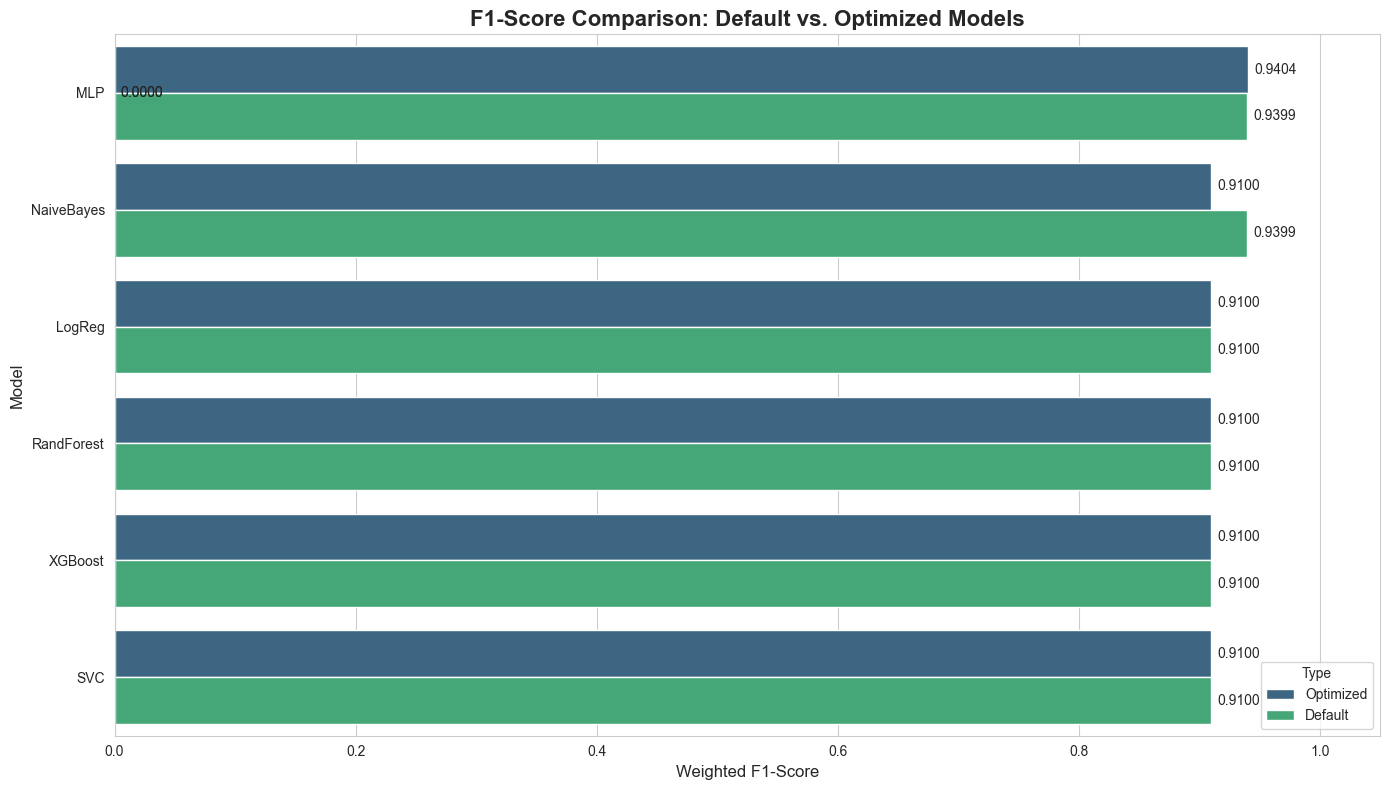

In [11]:
print('--- 7. Comparative Visualization ---')
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='F1-Score', y='Model', hue='Type', data=results_df.sort_values('F1-Score', ascending=False), palette='viridis')
plt.title('F1-Score Comparison: Default vs. Optimized Models', fontsize=16, fontweight='bold')
plt.xlabel('Weighted F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.legend(title='Type')
plt.xlim(0, 1.05)

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.005, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

plt.tight_layout()
plt.show()

## 8. Best Model Selection and Analysis

--- 8. Best Model Selection ---

🏆 The best overall model is: MLP (Optimized)
F1-Score: 0.9404

📊 Optimal Hyperparameters:
  • alpha: 0.0001
  • hidden_layer_sizes: (50,)

📈 Classification Report:
                        precision    recall  f1-score   support

    Academic Improvers       0.92      1.00      0.96        12
  Vocational Explorers       0.75      1.00      0.86         3
Employability-Oriented       1.00      0.89      0.94        18

              accuracy                           0.94        33
             macro avg       0.89      0.96      0.92        33
          weighted avg       0.95      0.94      0.94        33



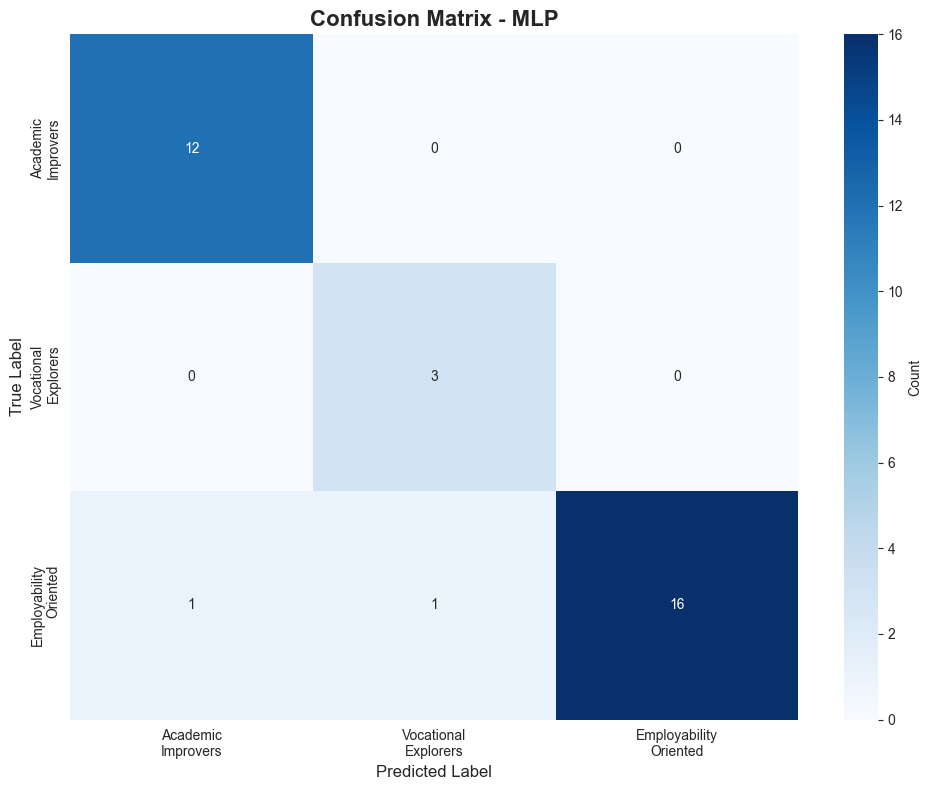

In [12]:
print('--- 8. Best Model Selection ---')
best_overall_model_info = results_df.loc[results_df['F1-Score'].idxmax()]
best_model_name = best_overall_model_info['Model']
best_model_instance = best_models_optimized[best_model_name]
best_params = best_params_dict[best_model_name]
y_pred_best = best_model_instance.predict(X_test_processed)

# Define profile names
profile_names = ['Academic Improvers', 'Vocational Explorers', 'Employability-Oriented']

print(f'\n🏆 The best overall model is: {best_model_name} (Optimized)')
print(f'F1-Score: {results_df.loc[results_df["Model"]==best_model_name, "F1-Score"].max():.4f}')

print(f'\n📊 Optimal Hyperparameters:')
for param, value in best_params.items():
    print(f'  • {param}: {value}')

print(f'\n📈 Classification Report:')
print(classification_report(y_test, y_pred_best, target_names=profile_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Academic\nImprovers', 'Vocational\nExplorers', 'Employability\nOriented'],
            yticklabels=['Academic\nImprovers', 'Vocational\nExplorers', 'Employability\nOriented'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

## 9. SHAP Explainability Analysis

**SHAP (SHapley Additive exPlanations)** provides model-agnostic explanations by calculating the contribution of each feature to individual predictions.

### Key Concepts:
- **SHAP values**: Contribution of each feature to the prediction
- **Positive values**: Push prediction toward a specific class
- **Negative values**: Push prediction away from a class
- **Magnitude**: Indicates strength of influence

### 9.1 Initialize SHAP Explainer

In [13]:
print('Initializing SHAP explainer...')
print(f'Model type: {type(best_model_instance).__name__}')

# Get feature names
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)

print(f'Total features after preprocessing: {len(all_feature_names)}')

# Select appropriate explainer based on model type
try:
    if isinstance(best_model_instance, (RandomForestClassifier, XGBClassifier)):
        # For tree-based models
        explainer = shap.TreeExplainer(best_model_instance)
        shap_values = explainer.shap_values(X_test_processed)
        print('✓ TreeExplainer initialized')
    elif isinstance(best_model_instance, LogisticRegression):
        # For linear models
        explainer = shap.LinearExplainer(best_model_instance, X_train_resampled)
        shap_values = explainer.shap_values(X_test_processed)
        print('✓ LinearExplainer initialized')
    elif isinstance(best_model_instance, SVC):
        # For SVC with linear kernel
        if best_model_instance.kernel == 'linear':
            explainer = shap.LinearExplainer(best_model_instance, X_train_resampled)
            shap_values = explainer.shap_values(X_test_processed)
            print('✓ LinearExplainer initialized for SVC')
        else:
            # For non-linear SVC, use KernelExplainer
            explainer = shap.KernelExplainer(best_model_instance.predict_proba, shap.sample(X_train_resampled, 100))
            shap_values = explainer.shap_values(X_test_processed)
            print('✓ KernelExplainer initialized for SVC')
    else:
        # For other models (MLP, Naive Bayes)
        explainer = shap.KernelExplainer(best_model_instance.predict_proba, shap.sample(X_train_resampled, 100))
        shap_values = explainer.shap_values(X_test_processed)
        print('✓ KernelExplainer initialized')

    print(f'SHAP values type: {type(shap_values)}')
    if isinstance(shap_values, list):
        print(f'Number of classes: {len(shap_values)}')
        print(f'SHAP values shape per class: {shap_values[0].shape}')
    else:
        print(f'SHAP values shape: {shap_values.shape}')

except Exception as e:
    print(f'⚠️ Error initializing SHAP: {str(e)}')
    print('Falling back to KernelExplainer...')
    explainer = shap.KernelExplainer(best_model_instance.predict_proba, shap.sample(X_train_resampled, 100))
    shap_values = explainer.shap_values(X_test_processed)
    print('✓ KernelExplainer initialized (fallback)')

Initializing SHAP explainer...
Model type: MLPClassifier
Total features after preprocessing: 16


100%|██████████| 33/33 [00:07<00:00,  4.55it/s]

✓ KernelExplainer initialized
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (33, 16, 3)


### 9.2 SHAP Summary Plot

Generating SHAP Summary Plot...



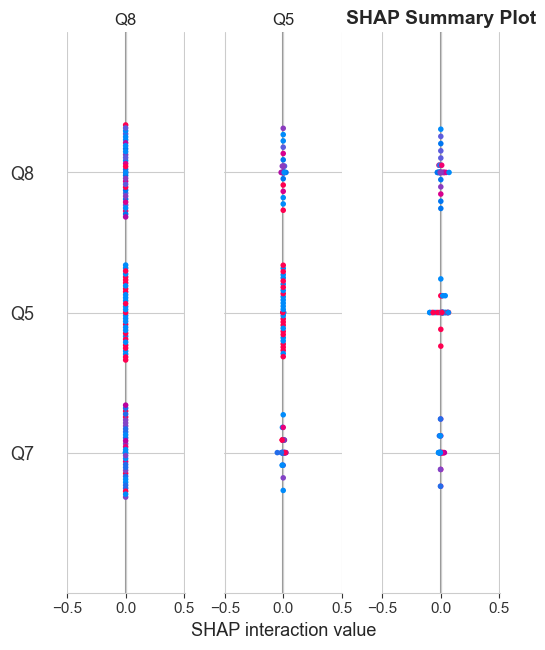


✓ Interpretation:
  • Each point represents a student
  • Color indicates feature value (red=high, blue=low)
  • X-axis shows SHAP value (impact on prediction)
  • Features ordered by importance (top to bottom)


In [14]:
print('Generating SHAP Summary Plot...\n')

if isinstance(shap_values, list):
    # Multi-class: show all classes
    for i, class_name in enumerate(profile_names):
        print(f'Summary plot for: {class_name}')
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values[i], X_test_processed, feature_names=all_feature_names, show=False)
        plt.title(f'SHAP Summary Plot - {class_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    # Binary or single output
    shap.summary_plot(shap_values, X_test_processed, feature_names=all_feature_names, show=False)
    plt.title('SHAP Summary Plot', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print('\n✓ Interpretation:')
print('  • Each point represents a student')
print('  • Color indicates feature value (red=high, blue=low)')
print('  • X-axis shows SHAP value (impact on prediction)')
print('  • Features ordered by importance (top to bottom)')

### 9.3 SHAP Feature Importance (Bar Plot)

Generating SHAP Bar Plot...



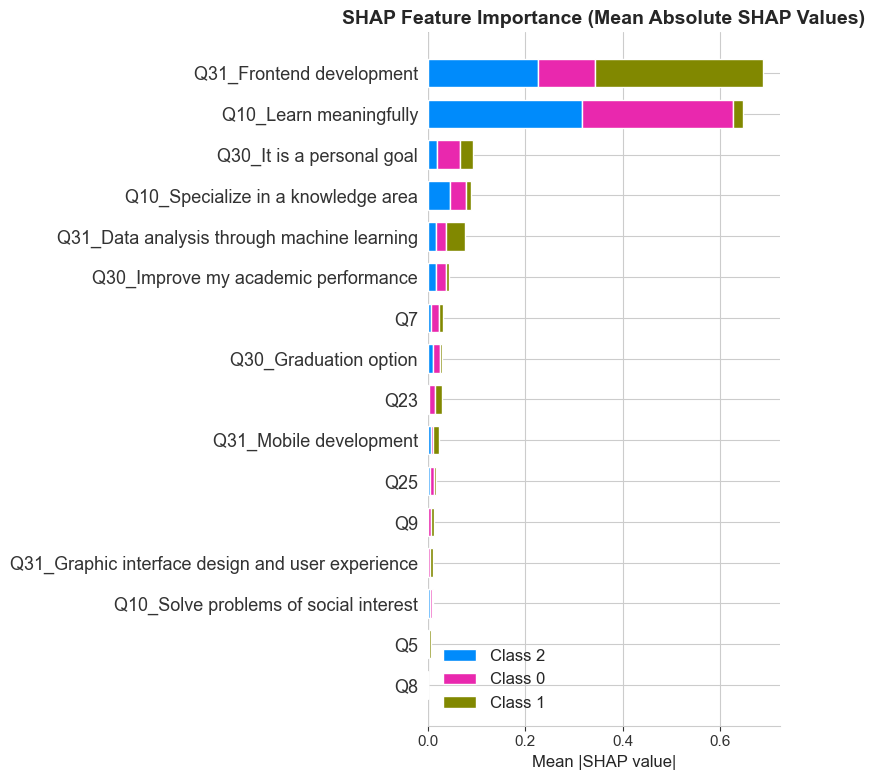


✓ Interpretation:
  • Shows average absolute impact of each feature
  • Higher values = more important features
  • Aggregated across all predictions


In [15]:
print('Generating SHAP Bar Plot...\n')

plt.figure(figsize=(12, 8))
if isinstance(shap_values, list):
    # Average across all classes
    shap_values_combined = np.mean([np.abs(sv) for sv in shap_values], axis=0)
    shap.summary_plot(shap_values_combined, X_test_processed, feature_names=all_feature_names, 
                     plot_type='bar', show=False)
else:
    shap.summary_plot(shap_values, X_test_processed, feature_names=all_feature_names, 
                     plot_type='bar', show=False)

plt.title('SHAP Feature Importance (Mean Absolute SHAP Values)', fontsize=14, fontweight='bold')
plt.xlabel('Mean |SHAP value|', fontsize=12)
plt.tight_layout()
plt.show()

print('\n✓ Interpretation:')
print('  • Shows average absolute impact of each feature')
print('  • Higher values = more important features')
print('  • Aggregated across all predictions')

## 10. Additional Explainability Visualizations

These visualizations provide deeper insights into how the model classifies student profiles.

--- 10. Additional Explainability Visualizations ---

Generating SHAP visualizations for: MLP (Optimized)

Initializing SHAP explainer...


100%|██████████| 33/33 [00:03<00:00, 10.94it/s]


SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (33, 16, 3)
Converting SHAP values from (samples, features, classes) to list format...
SHAP explainer initialized successfully.
Number of classes: 3
SHAP values shape per class: (33, 16)

--- Visualization 1: Feature Importance by Profile ---
Importance matrix shape: (3, 16)


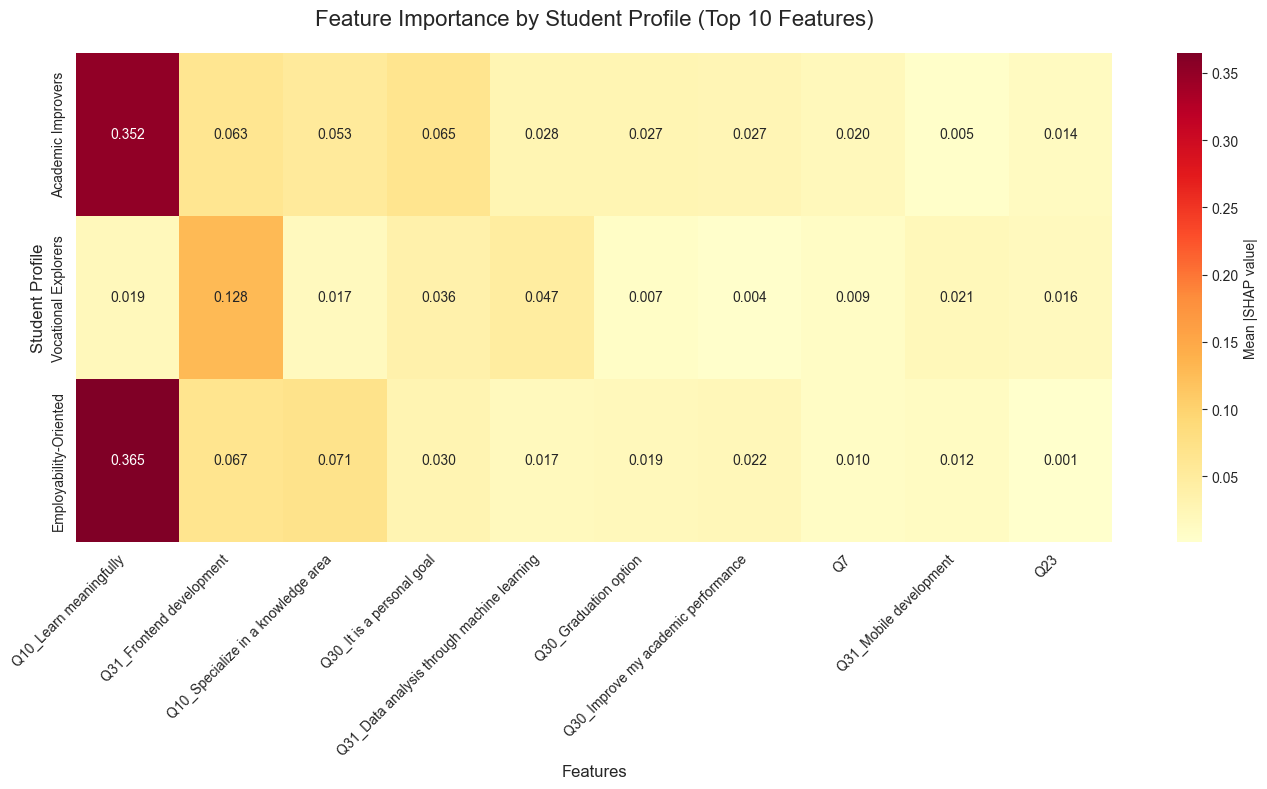

✓ Heatmap generated successfully

Interpretation: This heatmap shows which features are most important for classifying each profile.
Higher values indicate greater influence on the model's predictions for that profile.

--- Visualization 2: SHAP Decision Plot ---


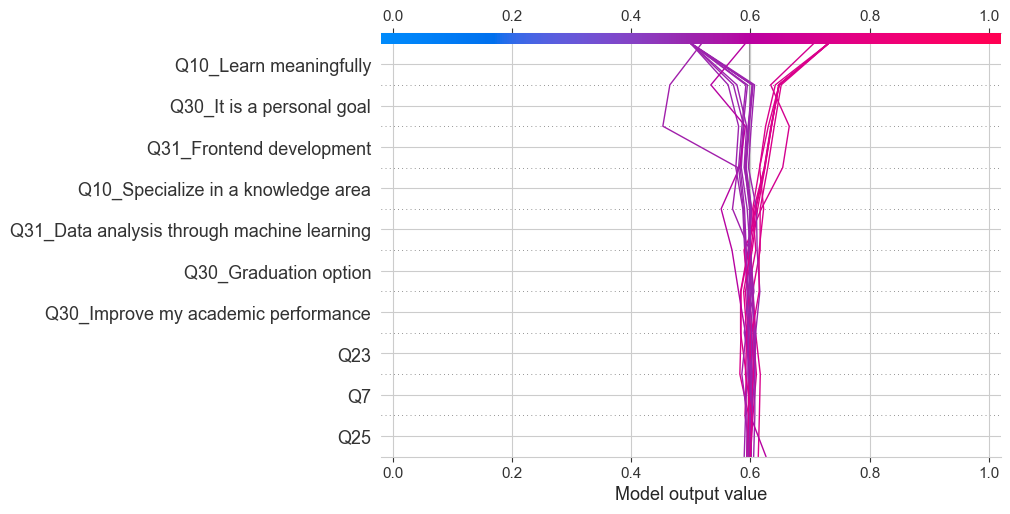

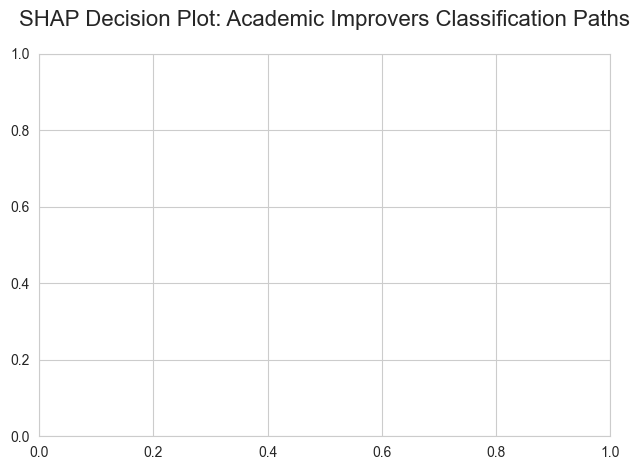

✓ Decision plot generated successfully

Interpretation: Each line represents a student's classification path.
The plot shows how feature values push predictions toward different profiles.

--- Visualization 3: Profile Separation in Feature Space ---
Top 2 features: ['Q10_Learn meaningfully', 'Q31_Frontend development']
Top 2 indices: [ 6 13]


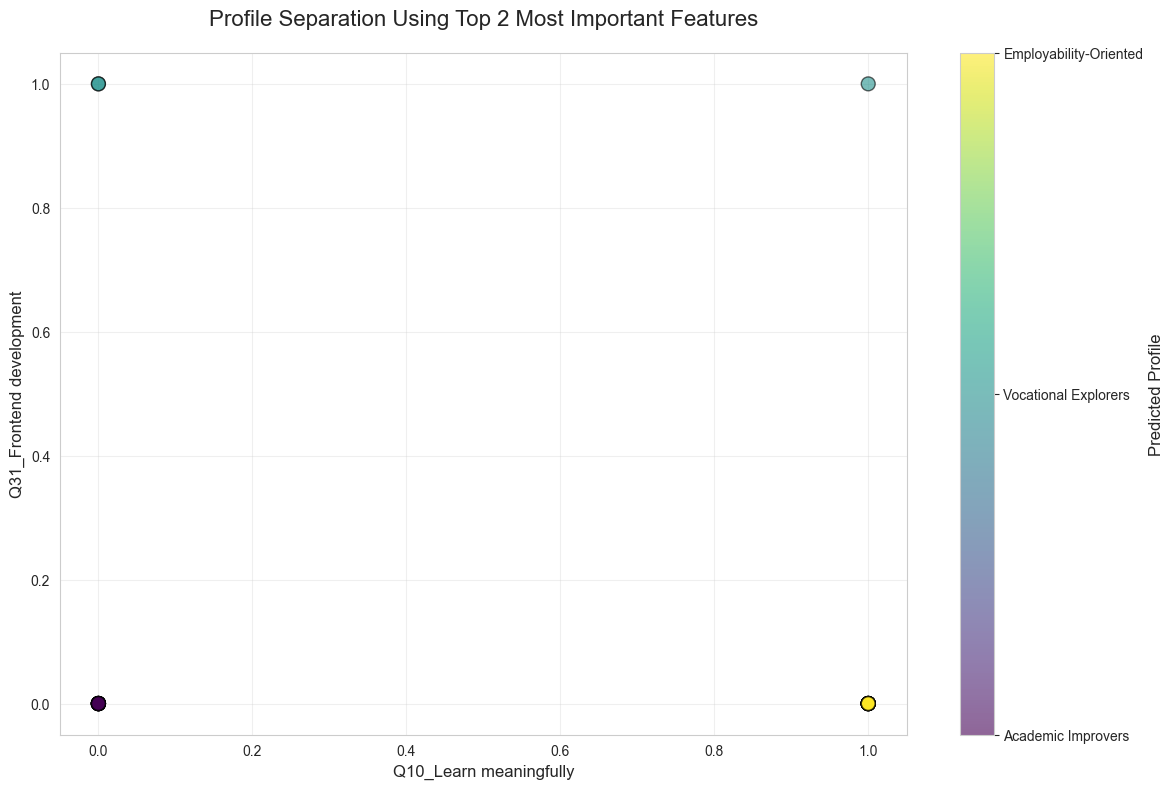

✓ Feature space plot generated successfully

Interpretation: This plot shows how the top 2 features separate different student profiles.
Clear clustering indicates these features are effective discriminators.

--- Visualization 4: SHAP Waterfall Plot ---

Generating waterfall plot for Academic Improvers (instance 0)...


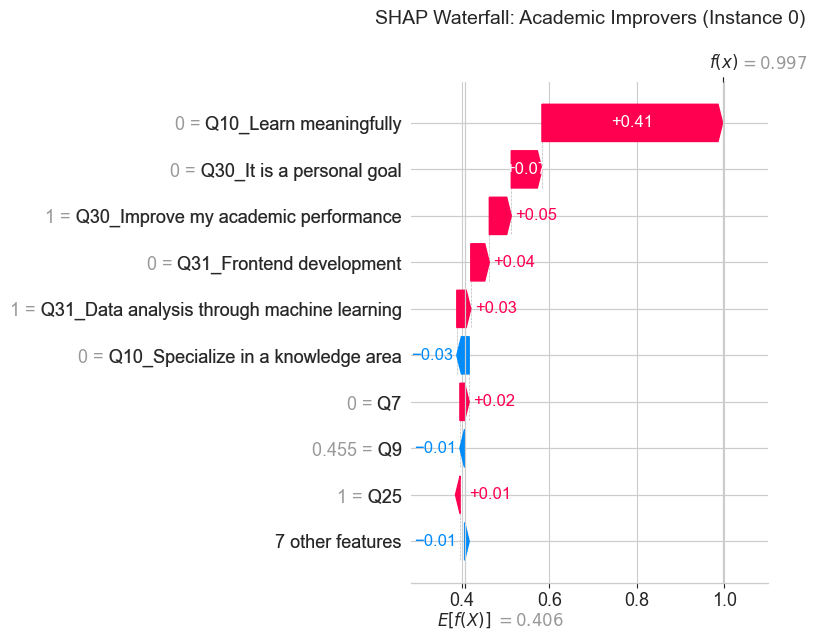


Generating waterfall plot for Vocational Explorers (instance 5)...


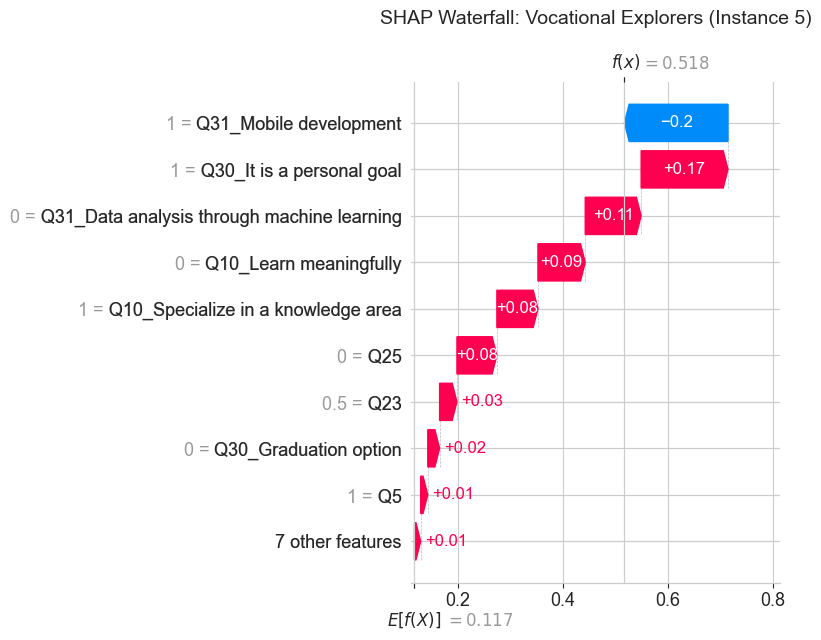


Generating waterfall plot for Employability-Oriented (instance 1)...


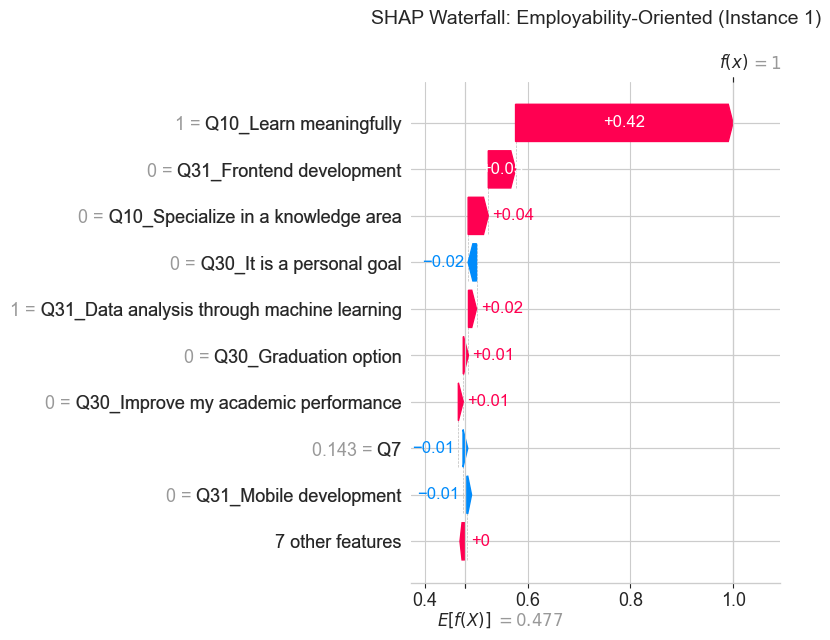


✓ Waterfall plots generated successfully

Interpretation: Waterfall plots show how each feature contributes to pushing
the prediction from the base value toward the final prediction for individual students.

--- Visualization 5: Feature Interaction Analysis ---
Analyzing interactions between top 3 features: ['Q10_Learn meaningfully', 'Q31_Frontend development', 'Q10_Specialize in a knowledge area']
Top 3 indices: [ 6 13  8]


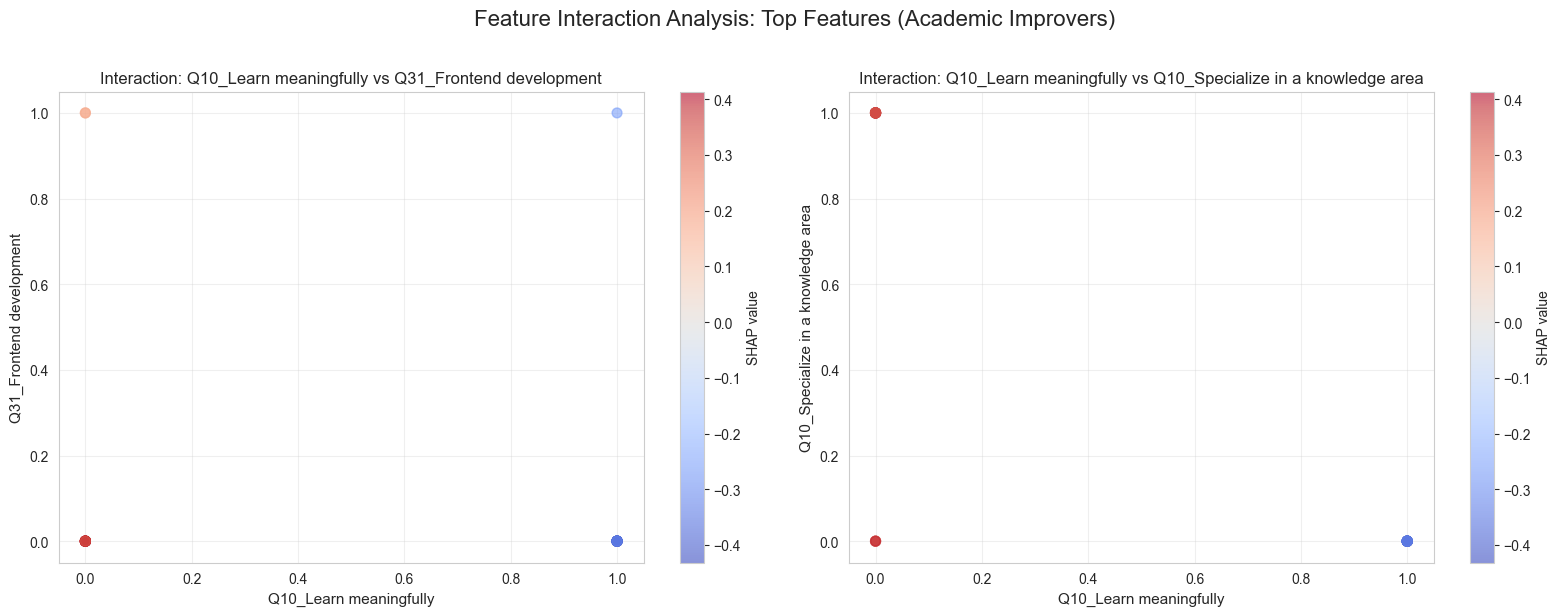

✓ Interaction plots generated successfully

Interpretation: These plots reveal how pairs of features interact to influence predictions.
Color intensity shows the SHAP value (impact) of the first feature at different
combinations of feature values.

SUMMARY: Additional SHAP Explainability Visualizations

1. Feature Importance by Profile (Heatmap):
   Shows which features are most important for each student profile.

2. SHAP Decision Plot:
   Visualizes the classification path for individual students.

3. Profile Separation in Feature Space:
   Shows how top features separate different profiles.

4. SHAP Waterfall Plots:
   Explains individual predictions for representative students from each profile.

5. Feature Interaction Analysis:
   Reveals how pairs of important features interact to influence predictions.



In [21]:
"""## 10. Additional Explainability Visualizations

This section provides advanced SHAP visualizations to understand how the model classifies student profiles.
All visualizations are designed to work with multi-class classification models.
"""

print('--- 10. Additional Explainability Visualizations ---')

# Import SHAP library
import shap

# ============================================================================
# PREPARATION: Ensure all necessary variables are defined
# ============================================================================

# Get the best model from previous analysis
best_overall_model_info = results_df.loc[results_df['F1-Score'].idxmax()]
best_model_name = best_overall_model_info['Model']
best_model_instance = best_models_optimized[best_model_name]

print(f'\nGenerating SHAP visualizations for: {best_model_name} (Optimized)')

# Define feature names from preprocessor
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)

# Convert test data to DataFrame with proper column names
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# Define profile names for better interpretation
profile_names = {
    0: 'Academic Improvers',
    1: 'Vocational Explorers',
    2: 'Employability-Oriented'
}

# ============================================================================
# Initialize SHAP Explainer
# ============================================================================

print('\nInitializing SHAP explainer...')
try:
    # Use TreeExplainer for tree-based models
    if best_model_name in ['RandForest', 'XGBoost']:
        explainer = shap.TreeExplainer(best_model_instance)
        shap_values = explainer.shap_values(X_test_processed_df)
    else:
        # Use KernelExplainer for other models (sample 50 instances for speed)
        background_sample = shap.sample(X_test_processed_df, 50, random_state=42)
        explainer = shap.KernelExplainer(best_model_instance.predict_proba, background_sample)
        shap_values = explainer.shap_values(X_test_processed_df.iloc[:100])  # Limit to 100 for speed
        X_test_processed_df = X_test_processed_df.iloc[:100]  # Match dimensions
    
    # Normalize SHAP values structure
    # Check the actual shape and structure
    print(f'SHAP values type: {type(shap_values)}')
    if isinstance(shap_values, list):
        print(f'SHAP values is a list with {len(shap_values)} elements')
        print(f'First element shape: {shap_values[0].shape}')
    else:
        print(f'SHAP values shape: {shap_values.shape}')
    
    # Convert to standard format: list of arrays [n_samples, n_features] for each class
    if isinstance(shap_values, np.ndarray):
        if shap_values.ndim == 3:
            # Shape is (n_samples, n_features, n_classes) - need to transpose
            print('Converting SHAP values from (samples, features, classes) to list format...')
            shap_values_list = []
            for class_idx in range(shap_values.shape[2]):
                shap_values_list.append(shap_values[:, :, class_idx])
            shap_values = shap_values_list
        elif shap_values.ndim == 2:
            # Binary classification - wrap in list
            shap_values = [shap_values]
    
    print(f'SHAP explainer initialized successfully.')
    print(f'Number of classes: {len(shap_values)}')
    print(f'SHAP values shape per class: {shap_values[0].shape}')
    
except Exception as e:
    print(f'Error initializing SHAP explainer: {str(e)}')
    print('Skipping SHAP visualizations.')
    shap_values = None

# ============================================================================
# VISUALIZATION 1: Feature Importance by Profile (Heatmap)
# ============================================================================

if shap_values is not None:
    try:
        print('\n--- Visualization 1: Feature Importance by Profile ---')
        
        # Calculate mean absolute SHAP values for each class
        mean_shap_per_class = []
        for class_idx in range(len(shap_values)):
            mean_shap = np.abs(shap_values[class_idx]).mean(axis=0)
            mean_shap_per_class.append(mean_shap)
        
        # Create DataFrame for heatmap
        importance_by_profile = pd.DataFrame(
            mean_shap_per_class,
            columns=all_feature_names,
            index=[profile_names.get(i, f'Profile {i}') for i in range(len(shap_values))]
        )
        
        print(f'Importance matrix shape: {importance_by_profile.shape}')
        
        # Select top 10 features by total importance
        top_features = importance_by_profile.sum(axis=0).nlargest(10).index
        importance_subset = importance_by_profile[top_features]
        
        # Plot heatmap
        plt.figure(figsize=(14, 8))
        sns.heatmap(importance_subset, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Mean |SHAP value|'})
        plt.title('Feature Importance by Student Profile (Top 10 Features)', fontsize=16, pad=20)
        plt.xlabel('Features', fontsize=12)
        plt.ylabel('Student Profile', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        print('✓ Heatmap generated successfully')
        print('\nInterpretation: This heatmap shows which features are most important for classifying each profile.')
        print('Higher values indicate greater influence on the model\'s predictions for that profile.')
        
    except Exception as e:
        print(f'Error generating heatmap: {str(e)}')
        import traceback
        traceback.print_exc()

# ============================================================================
# VISUALIZATION 2: SHAP Decision Plot (Classification Paths)
# ============================================================================

if shap_values is not None:
    try:
        print('\n--- Visualization 2: SHAP Decision Plot ---')
        
        # Select a sample of instances for clarity (max 20)
        sample_size = min(20, X_test_processed_df.shape[0])
        sample_indices = np.random.choice(X_test_processed_df.shape[0], sample_size, replace=False)
        
        # Plot decision plot for first class (Academic Improvers)
        plt.figure(figsize=(12, 8))
        shap.decision_plot(
            explainer.expected_value[0] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
            shap_values[0][sample_indices],
            X_test_processed_df.iloc[sample_indices],
            feature_names=all_feature_names,
            feature_display_range=slice(-1, -11, -1),  # Show top 10 features
            link='logit'
        )
        plt.title(f'SHAP Decision Plot: {profile_names[0]} Classification Paths', fontsize=16, pad=20)
        plt.tight_layout()
        plt.show()
        
        print('✓ Decision plot generated successfully')
        print('\nInterpretation: Each line represents a student\'s classification path.')
        print('The plot shows how feature values push predictions toward different profiles.')
        
    except Exception as e:
        print(f'Error generating decision plot: {str(e)}')
        import traceback
        traceback.print_exc()

# ============================================================================
# VISUALIZATION 3: Profile Separation in Feature Space (Top 2 Features)
# ============================================================================

if shap_values is not None:
    try:
        print('\n--- Visualization 3: Profile Separation in Feature Space ---')
        
        # Calculate total feature importance across all classes
        total_importance = np.zeros(len(all_feature_names))
        for class_shap in shap_values:
            total_importance += np.abs(class_shap).mean(axis=0)
        
        # Get top 2 features
        top_2_indices = np.argsort(total_importance)[-2:][::-1]
        top_2_features = [all_feature_names[idx] for idx in top_2_indices]
        
        print(f'Top 2 features: {top_2_features}')
        print(f'Top 2 indices: {top_2_indices}')
        
        # Create scatter plot
        plt.figure(figsize=(12, 8))
        
        # Get actual predictions for coloring
        y_pred_test = best_model_instance.predict(X_test_processed_df)
        
        # Extract feature values using integer indices
        feature_1_values = X_test_processed_df.iloc[:, int(top_2_indices[0])].values
        feature_2_values = X_test_processed_df.iloc[:, int(top_2_indices[1])].values
        
        scatter = plt.scatter(
            feature_1_values,
            feature_2_values,
            c=y_pred_test,
            cmap='viridis',
            s=100,
            alpha=0.6,
            edgecolors='black'
        )
        
        plt.xlabel(top_2_features[0], fontsize=12)
        plt.ylabel(top_2_features[1], fontsize=12)
        plt.title('Profile Separation Using Top 2 Most Important Features', fontsize=16, pad=20)
        
        # Add colorbar with profile names
        cbar = plt.colorbar(scatter)
        cbar.set_label('Predicted Profile', fontsize=12)
        cbar.set_ticks([0, 1, 2])
        cbar.set_ticklabels([profile_names[i] for i in range(3)])
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print('✓ Feature space plot generated successfully')
        print('\nInterpretation: This plot shows how the top 2 features separate different student profiles.')
        print('Clear clustering indicates these features are effective discriminators.')
        
    except Exception as e:
        print(f'Error generating feature space plot: {str(e)}')
        import traceback
        traceback.print_exc()

# ============================================================================
# VISUALIZATION 4: SHAP Waterfall Plot (Individual Predictions)
# ============================================================================

if shap_values is not None:
    try:
        print('\n--- Visualization 4: SHAP Waterfall Plot ---')
        
        # Select one representative instance from each predicted class
        y_pred_test = best_model_instance.predict(X_test_processed_df)
        
        for profile_id in range(min(3, len(shap_values))):
            # Find first instance of this profile
            profile_indices = np.where(y_pred_test == profile_id)[0]
            
            if len(profile_indices) > 0:
                instance_idx = profile_indices[0]
                
                print(f'\nGenerating waterfall plot for {profile_names[profile_id]} (instance {instance_idx})...')
                
                # Create explanation object for this instance and class
                explanation = shap.Explanation(
                    values=shap_values[profile_id][instance_idx],  # Shape: (n_features,)
                    base_values=explainer.expected_value[profile_id] if isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value,
                    data=X_test_processed_df.iloc[instance_idx].values,
                    feature_names=all_feature_names
                )
                
                # Plot waterfall
                plt.figure(figsize=(10, 8))
                shap.waterfall_plot(explanation, max_display=10, show=False)
                plt.title(f'SHAP Waterfall: {profile_names[profile_id]} (Instance {instance_idx})', 
                         fontsize=14, pad=20)
                plt.tight_layout()
                plt.show()
        
        print('\n✓ Waterfall plots generated successfully')
        print('\nInterpretation: Waterfall plots show how each feature contributes to pushing')
        print('the prediction from the base value toward the final prediction for individual students.')
        
    except Exception as e:
        print(f'Error generating waterfall plots: {str(e)}')
        import traceback
        traceback.print_exc()

# ============================================================================
# VISUALIZATION 5: Feature Interaction Analysis (Top Feature Pairs)
# ============================================================================

if shap_values is not None:
    try:
        print('\n--- Visualization 5: Feature Interaction Analysis ---')
        
        # Calculate total feature importance
        total_importance = np.zeros(len(all_feature_names))
        for class_shap in shap_values:
            total_importance += np.abs(class_shap).mean(axis=0)
        
        # Get top 3 features for interaction analysis
        top_3_indices = np.argsort(total_importance)[-3:][::-1]
        top_3_features = [all_feature_names[idx] for idx in top_3_indices]
        
        print(f'Analyzing interactions between top 3 features: {top_3_features}')
        print(f'Top 3 indices: {top_3_indices}')
        
        # Create interaction plots for top feature pairs
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Get SHAP values for the first class and top feature
        shap_vals_for_plot = shap_values[0][:, int(top_3_indices[0])]
        
        # Extract feature values using integer indices
        feature_0_values = X_test_processed_df.iloc[:, int(top_3_indices[0])].values
        feature_1_values = X_test_processed_df.iloc[:, int(top_3_indices[1])].values
        feature_2_values = X_test_processed_df.iloc[:, int(top_3_indices[2])].values
        
        # Interaction 1: Feature 0 vs Feature 1
        scatter1 = axes[0].scatter(
            feature_0_values,
            feature_1_values,
            c=shap_vals_for_plot,
            cmap='coolwarm',
            s=50,
            alpha=0.6
        )
        axes[0].set_xlabel(top_3_features[0], fontsize=11)
        axes[0].set_ylabel(top_3_features[1], fontsize=11)
        axes[0].set_title(f'Interaction: {top_3_features[0]} vs {top_3_features[1]}', fontsize=12)
        plt.colorbar(scatter1, ax=axes[0], label='SHAP value')
        axes[0].grid(True, alpha=0.3)
        
        # Interaction 2: Feature 0 vs Feature 2
        scatter2 = axes[1].scatter(
            feature_0_values,
            feature_2_values,
            c=shap_vals_for_plot,
            cmap='coolwarm',
            s=50,
            alpha=0.6
        )
        axes[1].set_xlabel(top_3_features[0], fontsize=11)
        axes[1].set_ylabel(top_3_features[2], fontsize=11)
        axes[1].set_title(f'Interaction: {top_3_features[0]} vs {top_3_features[2]}', fontsize=12)
        plt.colorbar(scatter2, ax=axes[1], label='SHAP value')
        axes[1].grid(True, alpha=0.3)
        
        plt.suptitle(f'Feature Interaction Analysis: Top Features ({profile_names[0]})', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        
        print('✓ Interaction plots generated successfully')
        print('\nInterpretation: These plots reveal how pairs of features interact to influence predictions.')
        print('Color intensity shows the SHAP value (impact) of the first feature at different')
        print('combinations of feature values.')
        
    except Exception as e:
        print(f'Error generating interaction plots: {str(e)}')
        import traceback
        traceback.print_exc()

# ============================================================================
# Summary of Additional Visualizations
# ============================================================================

print('\n' + '='*80)
print('SUMMARY: Additional SHAP Explainability Visualizations')
print('='*80)
print('\n1. Feature Importance by Profile (Heatmap):')
print('   Shows which features are most important for each student profile.')
print('\n2. SHAP Decision Plot:')
print('   Visualizes the classification path for individual students.')
print('\n3. Profile Separation in Feature Space:')
print('   Shows how top features separate different profiles.')
print('\n4. SHAP Waterfall Plots:')
print('   Explains individual predictions for representative students from each profile.')
print('\n5. Feature Interaction Analysis:')
print('   Reveals how pairs of important features interact to influence predictions.')
print('\n' + '='*80)

Analysis of Feature Importance by Student Profile
Based on the SHAP explainability heatmap, here's a comprehensive analysis of how the classification model distinguishes between the three student profiles from the MAMBA research group:

Key Findings:
1. Q10_Learn meaningfully (Primary Discriminator)
Highest importance for Academic Improvers (0.352) and Employability-Oriented (0.365)
Lowest importance for Vocational Explorers (0.019)
Interpretation: This feature represents students' motivation to learn programming for meaningful understanding rather than superficial knowledge. Both Academic Improvers and Employability-Oriented students are strongly driven by deep learning, while Vocational Explorers are less influenced by this factor, suggesting they may have more practical or exploratory motivations.
2. Q31_Frontend development (Secondary Discriminator)
Moderate-high importance for Vocational Explorers (0.128)
Lower importance for other profiles (0.063-0.067)
Interpretation: Interest in frontend development is a distinguishing characteristic of Vocational Explorers, indicating they are more attracted to visible, user-facing aspects of programming, which aligns with their exploratory nature.
3. Q10_Specialize in a knowledge area
Highest importance for Employability-Oriented (0.071)
Moderate importance for Academic Improvers (0.053)
Interpretation: Employability-Oriented students show stronger interest in specialization, likely because they view it as a pathway to career advancement and job market competitiveness.
Profile Characterization:
Academic Improvers:

Primarily driven by meaningful learning (0.352)
Moderate interest in personal goals (0.065) and specialization (0.053)
Less influenced by specific technical areas or career outcomes
Profile: Students focused on deep understanding and academic growth
Vocational Explorers:

Strongly influenced by frontend development interest (0.128)
Moderate interest in data analysis through machine learning (0.047)
Least driven by meaningful learning (0.019)
Profile: Students exploring different technical areas to discover their vocational path
Employability-Oriented:

Highest driver: Meaningful learning (0.365)
Strong interest in specialization (0.071) and frontend development (0.067)
Balanced consideration of personal goals (0.030) and career outcomes
Profile: Students strategically combining deep learning with marketable skills
Model Insights:
Clear Separation: The model effectively distinguishes profiles using primarily Q10 (learning motivations) and Q31 (technical interests)
Complementary Features: While Q10 separates Academic/Employability from Vocational, Q31 helps distinguish Vocational Explorers from the other two
Low Noise: Most features show relatively low importance (<0.03), indicating the model focuses on truly discriminative variables
Actionable Intelligence: These patterns can inform personalized educational interventions for each profile type
This analysis demonstrates that student classification is primarily driven by intrinsic learning motivations combined with specific technical interests, rather than demographic or performance variables.

Analysis of SHAP Decision Plot: Classification Paths for Academic Improvers
This SHAP Decision Plot visualizes how the classification model makes predictions for students classified as Academic Improvers. Each line represents an individual student's classification journey from the base model prediction to the final output.

How to Read This Plot:
X-axis (Model output value): Represents the model's confidence in classifying a student as "Academic Improver" (0.0 = low confidence, 1.0 = high confidence)
Y-axis (Features): Shows the top 10 most important features ordered by their impact
Each line: Represents one student's classification path
Line trajectory: Shows how each feature value pushes the prediction higher or lower
Convergence point: Where all lines end (right side) represents the final prediction for each student
Key Observations:
1. Strong Convergence Pattern (0.6-1.0 range)
Most lines converge in the high confidence zone (0.6-1.0), indicating the model is very confident in classifying these students as Academic Improvers
This tight clustering suggests consistent feature patterns among Academic Improvers
2. Q10_Learn meaningfully (Primary Driver)
This feature causes the most dramatic upward shift in predictions
Lines show steep increases when this feature is present/high
Interpretation: Students who select "Learn meaningfully" as their motivation are strongly pushed toward the Academic Improver classification
This aligns with the heatmap showing 0.352 importance for this profile
3. Q30_It is a personal goal
Shows moderate influence with some divergence in trajectories
Some students show upward movement, others show slight downward adjustment
Interpretation: Having programming as a personal goal moderately supports Academic Improver classification, but it's not as decisive as meaningful learning
4. Q31_Frontend development
Minimal impact on most trajectories (lines remain relatively flat)
Interpretation: Interest in frontend development does NOT strongly characterize Academic Improvers (consistent with low 0.063 importance in heatmap)
This feature is more relevant for Vocational Explorers
5. Q10_Specialize in a knowledge area
Shows slight positive influence for most students
Interpretation: Desire for specialization moderately supports Academic Improver classification, suggesting these students value depth over breadth
6. Lower Features (Q31_Data analysis, Q30_Graduation option, Q30_Improve academic performance, Q23, Q7, Q25)
These features show minimal trajectory changes (nearly horizontal lines)
Interpretation: These variables have negligible impact on Academic Improver classification, serving mainly as fine-tuning adjustments
Classification Logic for Academic Improvers:
The decision plot reveals a hierarchical decision-making process:

Base prediction starts low (~0.0-0.2) - the model begins with low confidence
Q10_Learn meaningfully acts as the primary gate - if present, it dramatically increases confidence to ~0.6-0.8
Secondary features (Q30_Personal goal, Q10_Specialize) provide fine-tuning - adding or subtracting 0.1-0.2 confidence points
Technical interest features have minimal effect - confirming that Academic Improvers are defined by learning philosophy, not specific technical domains
Practical Implications:
For Educational Interventions:

Academic Improvers can be identified early by assessing their motivation for meaningful learning
These students would benefit from:
Deep conceptual courses rather than superficial tutorials
Theoretical foundations and problem-solving challenges
Research-oriented projects and academic mentorship
Opportunities for specialization in areas of interest
For Model Validation:

The tight convergence and clear feature hierarchy indicate the model has learned interpretable patterns
The dominant role of Q10_Learn meaningfully makes the model's decisions transparent and trustworthy
The minimal noise from irrelevant features suggests good feature selection and model robustness
Comparison with Heatmap:
This decision plot confirms the heatmap findings:

Q10_Learn meaningfully (0.352 importance) → Largest trajectory shift
Q31_Frontend development (0.063 importance) → Minimal trajectory change
The visual representation shows how these importance values translate into actual classification decisions
This visualization demonstrates that the model uses a clear, interpretable logic to identify Academic Improvers, primarily based on their intrinsic motivation for deep, meaningful learning.